In [5]:
import sqlite3
from io import BytesIO

import numpy as np
from PIL import Image
from tensorflow.keras import layers, models


def load_data_from_db(test, target_size=(128, 128)):
    conn = sqlite3.connect('images.db')
    cursor = conn.cursor()
    cursor.execute("SELECT imagine, sepia FROM Imagini WHERE test = ?", (True if test == 1 else False,))
    rows = cursor.fetchall()
    conn.close()

    x = []
    y = []
    for row in rows:
        imagine_blob, sepia = row
        imagine_bytes = BytesIO(imagine_blob)
        imagine = Image.open(imagine_bytes)
        
        if imagine.mode == "P":
            imagine = imagine.convert("RGBA")
        if imagine.mode != 'RGB':
            imagine = imagine.convert('RGB')

        imagine = imagine.resize(target_size)

        imagine = np.array(imagine) / 255.0

        x.append(imagine)
        y.append(1 if sepia else 0)

    x = np.array(x)
    y = np.array(y)
    return x, y


In [6]:
train_input, train_output = load_data_from_db(0)
test_input, test_output = load_data_from_db(1)

In [7]:
from keras.src.callbacks import EarlyStopping
from keras.src.optimizers import Adam
from keras.src.layers import Dropout, BatchNormalization
from keras import Input


def build_model(input_shape):
    model = models.Sequential([
        Input(input_shape),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.30),
        layers.Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.30),
        layers.Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.30),
        layers.Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.30),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def build_model2(input_shape):
    model = models.Sequential([
        Input(input_shape),
        layers.Flatten(),
        layers.Dense(512),
        layers.LeakyReLU(negative_slope=0.01),
        BatchNormalization(),
        Dropout(0.30),
        layers.Dense(256),
        layers.LeakyReLU(negative_slope=0.01),
        BatchNormalization(),
        Dropout(0.30),
        layers.Dense(128),
        layers.LeakyReLU(negative_slope=0.01),
        BatchNormalization(),
        Dropout(0.30),
        layers.Dense(64),
        layers.LeakyReLU(negative_slope=0.01),
        BatchNormalization(),
        Dropout(0.30),
        layers.Dense(32),
        layers.LeakyReLU(negative_slope=0.01),
        BatchNormalization(),
        Dropout(0.30),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

input_shape = train_input.shape[1:]
model = build_model(input_shape)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])

model.fit(train_input, train_output, epochs=10)

predicted = model.predict(test_input)
predicted = [1 if p > 0.5 else 0 for p in predicted]
print(predicted)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.5208 - loss: 1.0087 - precision: 0.4931 - recall: 0.5447
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.5385 - loss: 0.8268 - precision: 0.5502 - recall: 0.4840
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.6104 - loss: 0.7300 - precision: 0.5908 - recall: 0.6814
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6427 - loss: 0.6903 - precision: 0.6873 - recall: 0.6139
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7698 - loss: 0.4993 - precision: 0.8048 - recall: 0.7649
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6979 - loss: 0.6484 - precision: 0.6767 - recall: 0.7050
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.6521 - loss: 0.6219 - precision: 0.6863 - recall: 0.6116
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8125 - loss: 0.4910 - precision: 0.8054 - recall: 0.8218
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━

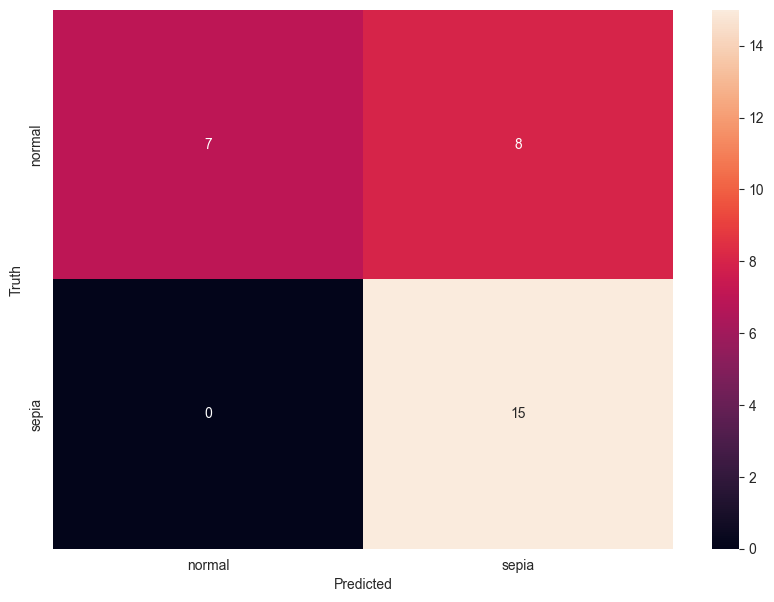

In [8]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_output, predicted)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=["normal", "sepia"], yticklabels=["normal", "sepia"])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()